mall sample of the text generated by a Char-RNN model after it was trained on all of Shakespeare’s work:

PANDARUS:

Alas, I think he shall be come approached and the day

When little srain would be attain’d into being never fed,

And who is but a chain and subjects of his death,

I should not sleep.

Not exactly a masterpiece, but it is still impressive that the model was able to learn words, grammar, proper punctuation, and more, just by learning to predict the next character in a sentence

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

     |████████████████████████████████| 1.1MB 9.8MB/s 


# Char-RNN

## Splitting a sequence into batches of shuffled windows

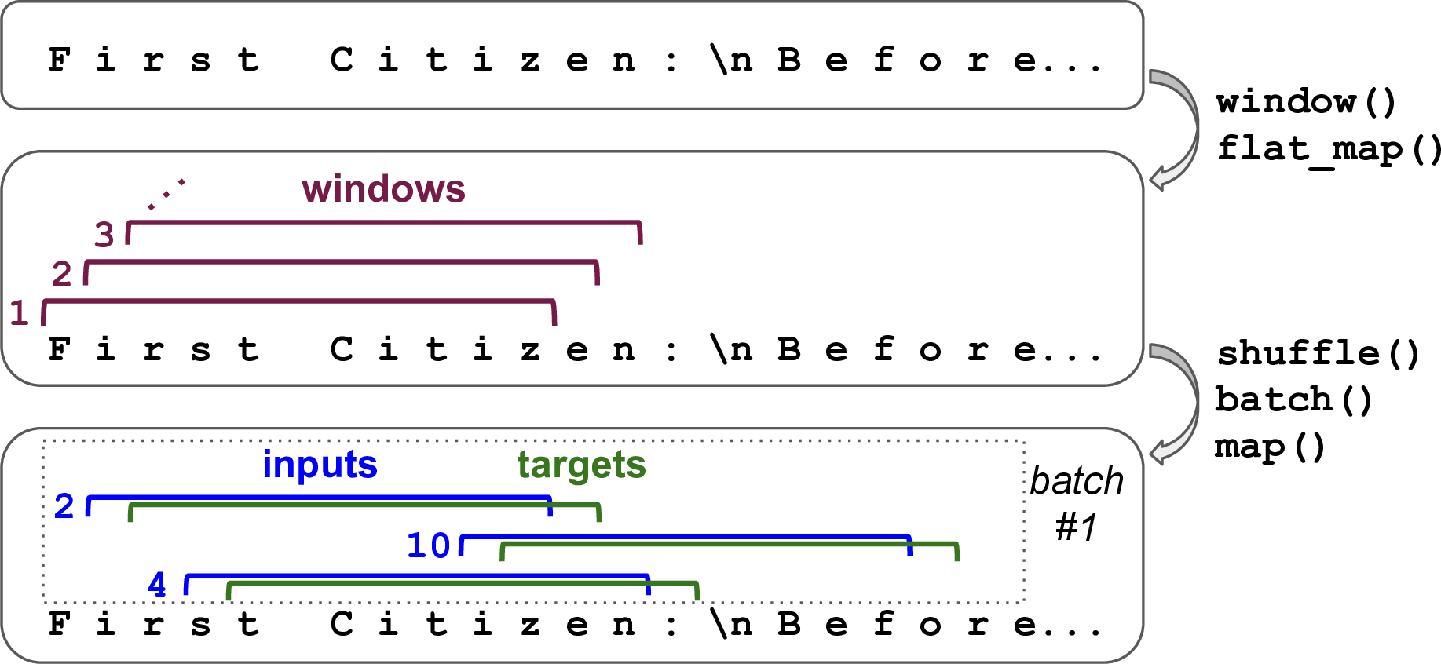

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [8]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [9]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [10]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [11]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [15]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [16]:
dataset = dataset.prefetch(1)

In [17]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Epoch 1/10
  329/31370 [..............................] - ETA: 5:21:00 - loss: 2.5472

## Using the Model to Generate Text

In [ ]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [ ]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [ ]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

In [ ]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [ ]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the belly the charges of the other words
and belly 


In [ ]:
print(complete_text("t", temperature=1))

thing! they know't.

biondello:
for you are the own


In [ ]:
print(complete_text("t", temperature=2))

th no cyty
use ffor was firive this toighingaber; b
